In [1]:
### Import libraries 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import scipy 
import re
import os
import sys 
import matplotlib.dates
# import sqlite3
# import sqlalchemy

# import warnings
from datetime import datetime
from tabulate import tabulate
from matplotlib import style
style.use('dark_background')


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("clean.csv", index_col=0)
total_click=0
temp_click=np.zeros(10000)
index=np.zeros(10000)
for i in np.array(range(0,10000,1)):
    total_click=total_click+df.click[i+1]
    index[i] = i+1
    temp_click[i]=total_click
#    acme['Clickcount'][i]=total_click
df['total_count']=temp_click
df['id']=index
df['1'] = pd.get_dummies(df['rank'])[1]
df['2'] = pd.get_dummies(df['rank'])[2]
df['3'] = pd.get_dummies(df['rank'])[3]
df['4'] = pd.get_dummies(df['rank'])[4]
df['5'] = pd.get_dummies(df['rank'])[5]
df['nov'] = pd.get_dummies(df['number_of_vehicles'])[2]
df['nod'] = pd.get_dummies(df['number_of_drivers'])[2]
df = df.drop('number_of_vehicles',axis=1)
df = df.drop('number_of_drivers',axis=1)
df=df.astype('int32')

temp_click[0]

1.0

In [4]:
df.head()

,click,currently_insured,rank,policies sold,married,total_count,id,1,2,3,4,5,nov,nod
impression_id,,,,,,,,,,,,,,
1,1,0,1,1,1,1,1,1,0,0,0,0,0,0
2,0,0,4,0,1,1,2,0,0,0,1,0,1,0
3,0,0,2,0,0,1,3,0,1,0,0,0,0,0
4,0,1,5,0,1,1,4,0,0,0,0,1,1,0
5,0,1,4,0,0,1,5,0,0,0,1,0,1,1


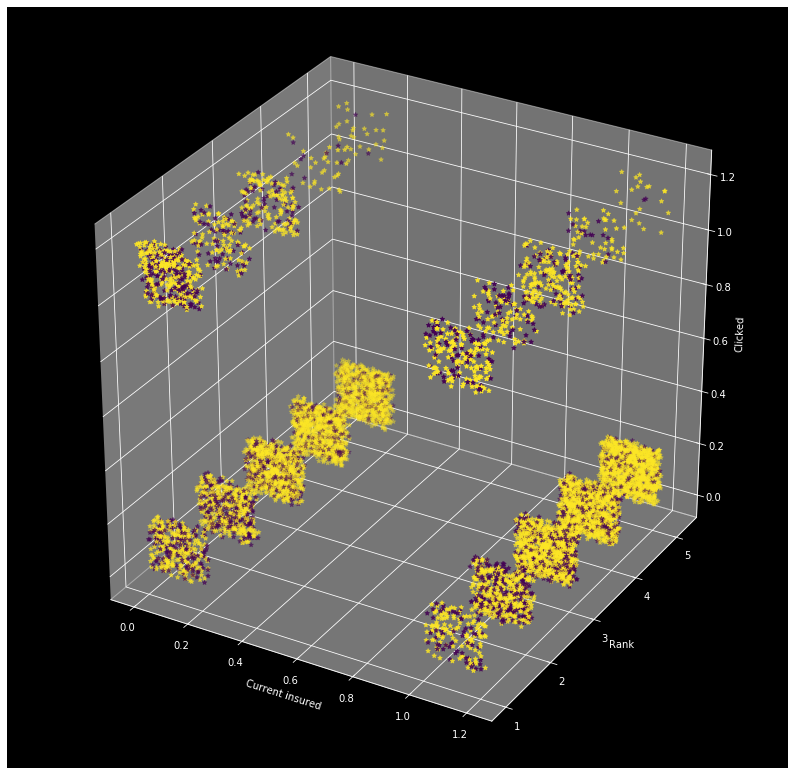

In [5]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
RAND_RANGE = .2
x = np.array(df['currently_insured'])+np.random.uniform(0,RAND_RANGE,10000)
y = np.array(df['rank'])+np.random.uniform(0,RAND_RANGE,10000)
z = np.array(df['click'])+np.random.uniform(0,RAND_RANGE,10000)

ax.scatter(x, y, z, c=df['married'], marker='*')
ax.set_xlabel('Current insured')
ax.set_ylabel('Rank')
ax.set_zlabel('Clicked')

plt.show()

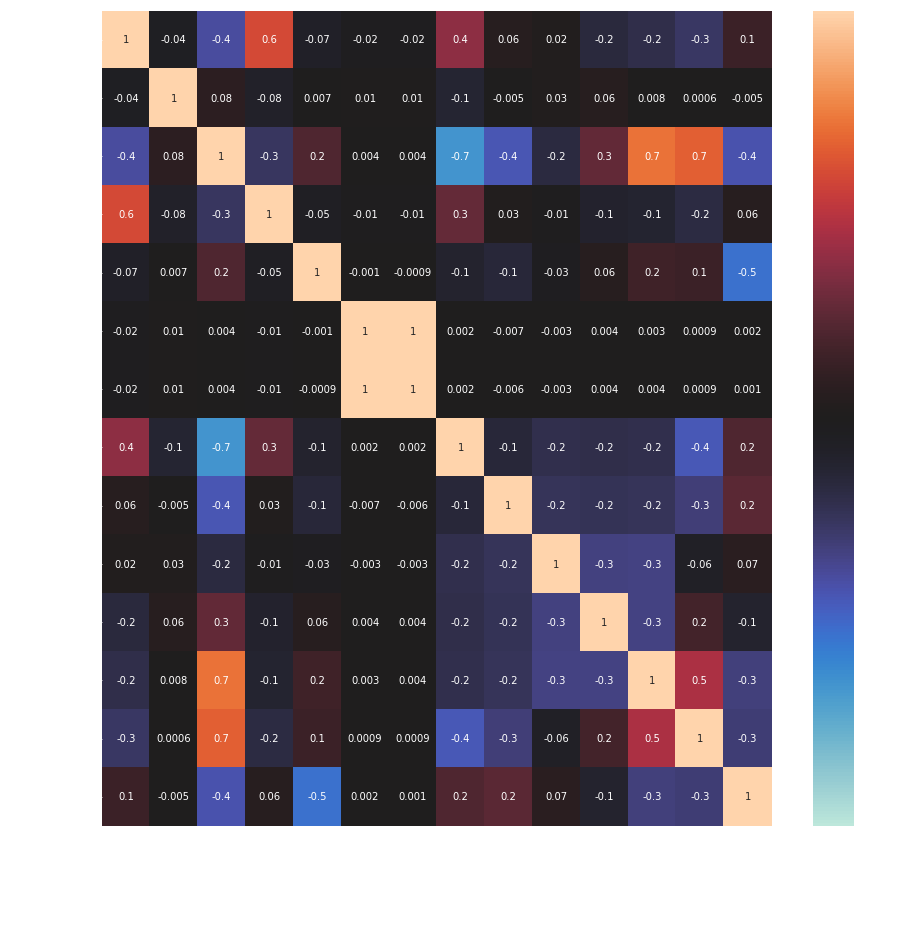

In [6]:
plt.figure(figsize=(15,15))

sns.heatmap(df.corr(),annot=True,fmt='.1g', vmin=-1, vmax=1, center= 0)


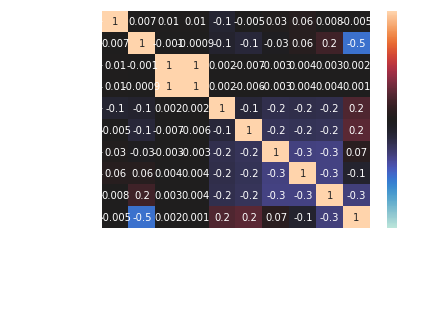

In [7]:
predictdf=df.drop(columns=['click','policies sold','rank', 'nov'])
sns.heatmap(predictdf.corr(),annot=True,fmt='.1g', vmin=-1, vmax=1, center= 0)


# Classification problem

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss, recall_score, confusion_matrix, \
                            auc, accuracy_score, roc_curve

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nov','nod']), df['click'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nov']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'nod']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', '1','2','3','4','5']), df['click'], test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['click','policies sold','rank', 'total_count']), df['click'], test_size=0.2, random_state=42)

#Prediction for policysold
#X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['policies sold','rank']), df['policies sold'], test_size=0.2, random_state=42)

In [10]:
poly = PolynomialFeatures(degree = 2, interaction_only=True)
poly.fit(X_train, y_train)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=True,
                   order='C')

In [11]:
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)


# Logistic Regression

In [12]:
logiReg = LogisticRegression()
logiReg.fit(X_train, y_train)
y_pred_logi = logiReg.predict_proba(X_test)[:,1]
p_range=np.array(range(1, 4000,10))/ 10000
#Initialize the accuracy and recall matrix
acc_temp=np.zeros(len(p_range))
rec_temp=np.zeros(len(p_range))
realp_temp=np.zeros(len(p_range))
auc_temp=np.zeros(len(p_range))
logloss_temp=np.zeros(len(p_range))

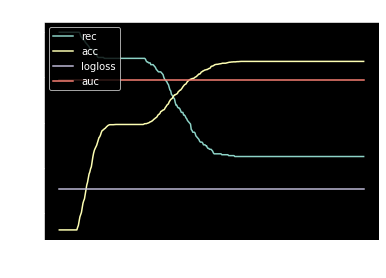

In [13]:
p_index=0
for p in p_range:
    threshold = p
    y_pred_prob = y_pred_logi
    y_pred = y_pred_prob > threshold
    #print('p=', p)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)    
    #print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    #print('Log loss:', log_loss(y_test, y_pred_prob))
    #print('Accuracy score:', accuracy_score(y_test, y_pred)) 
    #print("Recall rate:", recall_score(y_test, y_pred))
    #print('AUC metric:', auc(fpr, tpr))
    auc_temp[p_index]=auc(fpr, tpr)
    logloss_temp[p_index]=log_loss(y_test, y_pred_prob)
    acc_temp[p_index]=accuracy_score(y_test, y_pred)
    rec_temp[p_index]=recall_score(y_test, y_pred)
    realp_temp[p_index]=p
    p_index=p_index+1

plotdata={"acc": acc_temp,
          "rec": rec_temp,
          "logloss": logloss_temp,
          "auc":auc_temp,
            "p": realp_temp,}
plotdf = pd.DataFrame(plotdata)
plt.plot(plotdf['p'],plotdf['rec'])
plt.plot(plotdf['p'],plotdf['acc'])
plt.plot(plotdf['p'],plotdf['logloss'])
plt.plot(plotdf['p'],plotdf['auc'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('p')
plt.legend(['rec', 'acc','logloss','auc'], loc='upper left')
plt.show()

Exam the special case with some special p

In [14]:
    threshold = 0.154
    y_pred_prob = y_pred_logi
    y_pred = y_pred_prob > threshold
    print('p=', threshold)
    print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    print('Log loss:', log_loss(y_test, y_pred_prob))
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print("Recall rate:", recall_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('AUC metric:', auc(fpr, tpr))


p= 0.154
Prob of clicking: 0.1255 0.3175
Log loss: 0.3082922617958333
Accuracy score: 0.727
Recall rate: 0.6772908366533864
AUC metric: 0.7893320941505562


In [15]:
confusion_matrix(y_test, y_pred)

array([[1284,  465],
       [  81,  170]], dtype=int64)

# Lasso

In [16]:
from sklearn.linear_model import Lasso

In [17]:
alpha=0.0004
lasso = Lasso(alpha, normalize = True, max_iter = 1000000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
threshold = 0.12
y_pred_prob_lasso = y_pred_lasso
y_pred_lasso = y_pred_prob_lasso > threshold
print('Log loss:', log_loss(y_test, y_pred_prob_lasso))
print('Accuracy score:', accuracy_score(y_test, y_pred_lasso)) 
print("Recall rate:", recall_score(y_test, y_pred_lasso))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_lasso)    
print('AUC metric:', auc(fpr, tpr))

Log loss: 0.3216883716852705
Accuracy score: 0.592
Recall rate: 0.8844621513944223
AUC metric: 0.7877432522625336


# Ridge

In [18]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
threshold = 0.165
y_pred_prob_ridge = y_pred_ridge
y_pred_ridge = y_pred_prob_ridge > threshold
print('Log loss:', log_loss(y_test, y_pred_prob_ridge))
print('Accuracy score:', accuracy_score(y_test, y_pred_ridge)) 
print("Recall rate:", recall_score(y_test, y_pred_ridge))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_ridge)    
print('AUC metric:', auc(fpr, tpr))

Log loss: 0.30795576479979386
Accuracy score: 0.726
Recall rate: 0.701195219123506
AUC metric: 0.7947489629816924


## Ensemble learning

In [19]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [20]:
y_pred_gb = gb_clf.predict_proba(X_test)[:,1]

In [21]:
for p in np.array(range(1500, 2700,2)) / 10000:
    threshold = p
    y_pred_prob = y_pred_gb
    y_pred = y_pred_gb > threshold
    print('p=', p)
    #print('Prob of clicking:', np.mean(y_test), np.mean(y_pred))
    #print('Log loss:', log_loss(y_test, y_pred_prob))
    print('Accuracy score:', accuracy_score(y_test, y_pred))
    print("Recall rate:", recall_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    print('AUC metric:', auc(fpr, tpr))

p= 0.15
Accuracy score: 0.6615
Recall rate: 0.7689243027888446
AUC metric: 0.7867808354916526
p= 0.1502
Accuracy score: 0.661
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1504
Accuracy score: 0.662
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1506
Accuracy score: 0.6625
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1508
Accuracy score: 0.663
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.151
Accuracy score: 0.6675
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1512
Accuracy score: 0.6675
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1514
Accuracy score: 0.668
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1516
Accuracy score: 0.669
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.1518
Accuracy score: 0.669
Recall rate: 0.7649402390438247
AUC metric: 0.7867808354916526
p= 0.152
Accuracy score: 0.6705
Recall rate: 0.76

AUC metric: 0.7867808354916526
p= 0.1698
Accuracy score: 0.76
Recall rate: 0.6374501992031872
AUC metric: 0.7867808354916526
p= 0.17
Accuracy score: 0.76
Recall rate: 0.6374501992031872
AUC metric: 0.7867808354916526
p= 0.1702
Accuracy score: 0.7605
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.1704
Accuracy score: 0.7605
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.1706
Accuracy score: 0.7605
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.1708
Accuracy score: 0.7605
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.171
Accuracy score: 0.763
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.1712
Accuracy score: 0.763
Recall rate: 0.6334661354581673
AUC metric: 0.7867808354916526
p= 0.1714
Accuracy score: 0.7675
Recall rate: 0.6294820717131474
AUC metric: 0.7867808354916526
p= 0.1716
Accuracy score: 0.768
Recall rate: 0.6294820717131474
AUC metric: 0.7867808354916526
p= 0.1718
Accuracy 

Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1914
Accuracy score: 0.8065
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1916
Accuracy score: 0.8065
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1918
Accuracy score: 0.8065
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.192
Accuracy score: 0.8065
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1922
Accuracy score: 0.8065
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1924
Accuracy score: 0.807
Recall rate: 0.5537848605577689
AUC metric: 0.7867808354916526
p= 0.1926
Accuracy score: 0.807
Recall rate: 0.545816733067729
AUC metric: 0.7867808354916526
p= 0.1928
Accuracy score: 0.807
Recall rate: 0.545816733067729
AUC metric: 0.7867808354916526
p= 0.193
Accuracy score: 0.81
Recall rate: 0.5418326693227091
AUC metric: 0.7867808354916526
p= 0.1932
Accuracy score: 0.81
Recall rate: 0.5418326693227091
AUC metric: 0.78678

Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2136
Accuracy score: 0.8435
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2138
Accuracy score: 0.8435
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.214
Accuracy score: 0.8435
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2142
Accuracy score: 0.848
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2144
Accuracy score: 0.848
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2146
Accuracy score: 0.848
Recall rate: 0.4820717131474104
AUC metric: 0.7867808354916526
p= 0.2148
Accuracy score: 0.8495
Recall rate: 0.47410358565737054
AUC metric: 0.7867808354916526
p= 0.215
Accuracy score: 0.8495
Recall rate: 0.47410358565737054
AUC metric: 0.7867808354916526
p= 0.2152
Accuracy score: 0.8495
Recall rate: 0.47410358565737054
AUC metric: 0.7867808354916526
p= 0.2154
Accuracy score: 0.8495
Recall rate: 0.47410358565737054
AUC metri

AUC metric: 0.7867808354916526
p= 0.2362
Accuracy score: 0.865
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2364
Accuracy score: 0.865
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2366
Accuracy score: 0.865
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2368
Accuracy score: 0.865
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.237
Accuracy score: 0.866
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2372
Accuracy score: 0.866
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2374
Accuracy score: 0.866
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2376
Accuracy score: 0.8665
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2378
Accuracy score: 0.8665
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.238
Accuracy score: 0.8665
Recall rate: 0.4541832669322709
AUC metric: 0.7867808354916526
p= 0.2382
Accuracy

Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2584
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2586
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2588
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.259
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2592
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2594
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2596
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2598
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.26
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.7867808354916526
p= 0.2602
Accuracy score: 0.8665
Recall rate: 0.450199203187251
AUC metric: 0.78678083

## Neural Network

In [22]:
from sklearn.neural_network import MLPClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense
import keras_metrics
from keras import backend as K
from keras.utils import to_categorical



Using TensorFlow backend.
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Users\Jigglypuff\anaconda3\envs\Erdos\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Users\Jigglypuff\anaconda3\en

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(100,),max_iter=1000)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [24]:
y_pred_nn = mlp.predict(X_test)
y_pred_prob_nn = mlp.predict_proba(X_test)

In [25]:
print(log_loss(y_test, y_pred_prob_nn))
print(accuracy_score(y_test, y_pred_nn))
print(recall_score(y_test, y_pred_nn))

0.40438848504969843
0.866
0.30677290836653387


In [26]:
print('meann of predict:',np.mean(y_pred_nn) )
print('meann of test:',np.mean(y_test) )


meann of predict: 0.0855
meann of test: 0.1255


# Multilayer NN

In [27]:
#define plot of recall,precision,loss
def recall_plot(history):
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def precision_plot(history):
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def loss_plot(history):
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss']) 
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch') 
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

In [28]:
def precision_threshold(threshold=0.5):
    def precision(y_true, y_pred):
        """Precision metric.
        Computes the precision over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # count the predicted positives
        predicted_positives = K.sum(y_pred)
        # Get the precision ratio
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        """Recall metric.
        Computes the recall over the whole batch using threshold_value.
        """
        threshold_value = threshold
        # Adaptation of the "round()" used before to get the predictions. Clipping to make sure that the predicted raw values are between 0 and 1.
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        # Compute the number of true positives. Rounding in prevention to make sure we have an integer.
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        # Compute the number of positive targets.
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

In [34]:
model = Sequential()
model.add(Dense(100, input_dim=10, activation='relu'))
model.add(Dense(100, activation='relu'))
#model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision_threshold(0.5), recall_threshold(0.5)])


In [35]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=10, batch_size=64)


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 0s 43us/step - loss: 13.1808 - precision: 0.1404 - recall: 1.0000 - val_loss: 13.4089 - val_precision: 0.1240 - val_recall: 1.0000
Epoch 2/10
8000/8000 [==============================] - 0s 19us/step - loss: 13.1808 - precision: 0.1404 - recall: 1.0000 - val_loss: 13.4089 - val_precision: 0.1240 - val_recall: 1.0000
Epoch 3/10
8000/8000 [==============================] - 0s 20us/step - loss: 13.1808 - precision: 0.1404 - recall: 1.0000 - val_loss: 13.4089 - val_precision: 0.1240 - val_recall: 1.0000
Epoch 4/10
8000/8000 [==============================] - 0s 20us/step - loss: 13.1808 - precision: 0.1404 - recall: 1.0000 - val_loss: 13.4089 - val_precision: 0.1240 - val_recall: 1.0000
Epoch 5/10
8000/8000 [==============================] - 0s 20us/step - loss: 13.1808 - precision: 0.1404 - recall: 1.0000 - val_loss: 13.4089 - val_precision: 0.1240 - val_recall: 1.0000
Epoch 6/10
8000/8

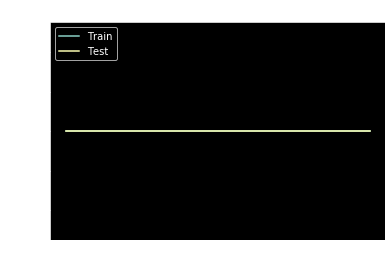

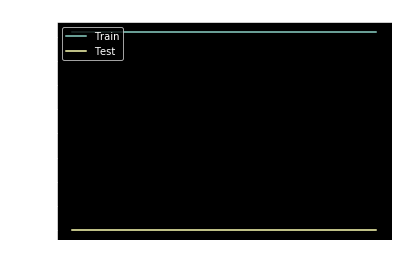

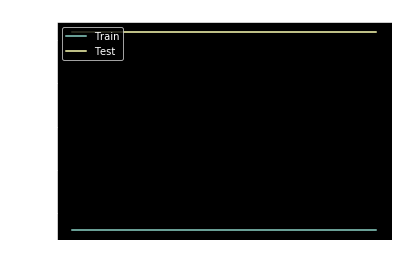

In [36]:
recall_plot(history)
precision_plot(history)
loss_plot(history)